In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

In [2]:
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# !curl -L "https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1" -o data.txt

In [4]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

In [5]:
with open('train.en', 'w', encoding='utf-8') as f_src, open('train.ru', 'w', encoding='utf-8') as f_dst:
    with open('data.txt', encoding='utf-8') as f:
        for line in f:
            src_line, dst_line = line.strip().split('\t')
            f_src.write(tokenize(src_line) + '\n')
            f_dst.write(tokenize(dst_line) + '\n')

In [6]:
bpe = {}
for lang in ['en', 'ru']:
    # Открываем входной файл для чтения с указанием кодировки, и файл для записи bpe-правил
    with open('./train.' + lang, encoding='utf-8') as f_in, \
         open('bpe_rules.' + lang, 'w', encoding='utf-8') as f_out:
        learn_bpe(f_in, f_out, num_symbols=8000)
    
    # Загружаем bpe-правила, опять с указанием кодировки
    with open('bpe_rules.' + lang, encoding='utf-8') as f_rules:
        bpe[lang] = BPE(f_rules)
    
    # Применяем BPE к обучающим данным и сохраняем результат
    with open('./train.' + lang, encoding='utf-8') as f_in, \
         open('train.bpe.' + lang, 'w', encoding='utf-8') as f_out:
        for line in f_in:
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:04<00:00, 1790.79it/s]


In [7]:
data_inp = np.array(open('./train.bpe.ru', encoding='utf-8').read().split('\n'))
data_out = np.array(open('./train.bpe.en', encoding='utf-8').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=2023,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .
out: this hotel is located in the centre of paris , 2 minutes from place de la ré@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: на полностью оборудованной мини - кухне можно самостоятельно готовить .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .
out: set under the roof or on the lower floors with bay windows looking out onto the park , they are all equipped with wi - fi access .



In [8]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [9]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1109,   29,    1,    1,    1],
        [   0, 3486, 1869,   29,    1,    1,    1,    1],
        [   0, 2922, 1833, 8034,   59, 3799,   29,    1],
        [   0, 6028, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1869,   29,    1,    1,    1,    1]])

back to words
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']


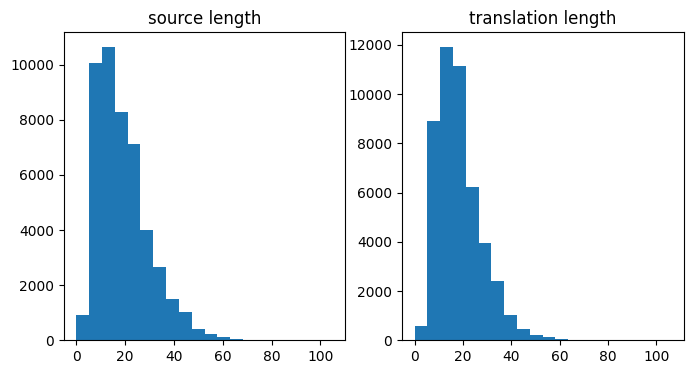

In [10]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

In [11]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [12]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [13]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, sequence length, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # input & hidden states
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [14]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

In [15]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


In [16]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [17]:
compute_bleu(model, dev_inp, dev_out)

0.0020583114022427644

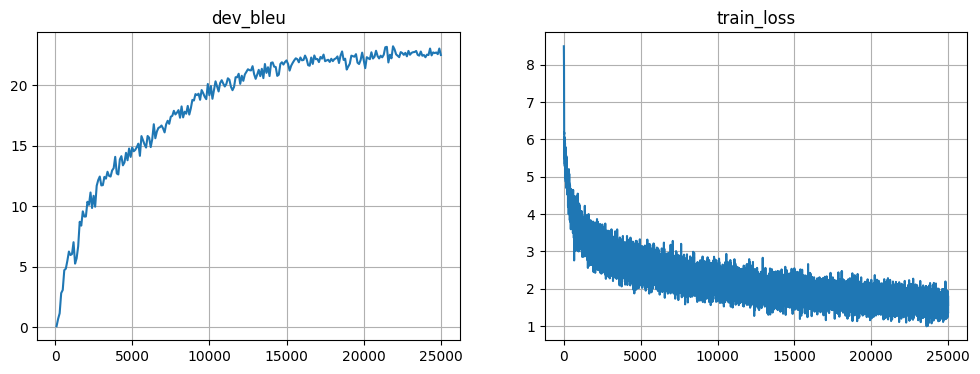

Mean loss=1.512


100%|██████████| 25000/25000 [40:33<00:00, 10.27it/s]


In [18]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [19]:
compute_bleu(model, dev_inp, dev_out)

22.523643306450086

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom comes with a bath and a hairdryer .

на территории можно сыграть в дартс и сквош .
guests can enjoy a game of billiards and darts .

апартаменты располагают гостиной зоной .
the apartments feature a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can prepare their meals in the fully equipped kitchen .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
the 2 - bedroom house has 2 bedrooms and 1 bathroom with a bath and a bidet , and a microwave .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
the l@@ ace gallery ' s coffee - friendly hotel ’ s coffee shop is served at the santa cruz ' s best value inn .



### Что можно улучшить

* продолжить эксперименты с различными RNN юнитами: gru/lstm; более глубокие архитектуры
* Сделать encoder двунаправленным, попробовать различные attention (additive, dot-product, multi-head, ...)
* улучшить training-процесс: lr sheduling, early stopping и т.п.
* заменить greedy инференс на другие варианты

## Домашнее задание 3

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab
from IPython.display import clear_output

# Фиксирование всех сидов для воспроизводимости
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Устройство:", device)

Устройство: cuda


#### 1. Модификация предобработки и ограничения размера словаря
- Добавляю предобработку текста: приведение к нижнему регистру и удаление лишних пробелов
- Увеличивааю размер словаря до 20000 для лучшего покрытия

In [2]:
def tokenize(x):
    """Предобработкой для BPE.
    1. Приведение к нижнему регистру
    2. Удаление лишних пробелов
    """
    x = x.lower()
    x = ' '.join(x.split())
    return x

example_text = "  This   is, an Example! of TEXT.   "
result = tokenize(example_text)
print("Исходная строка:", repr(example_text))
print("После токенизации:", repr(result))

Исходная строка: '  This   is, an Example! of TEXT.   '
После токенизации: 'this is, an example! of text.'


In [3]:
tokenizer = WordPunctTokenizer()

with open('train.en', 'w', encoding='utf-8') as f_src, open('train.ru', 'w', encoding='utf-8') as f_dst:
    with open('data.txt', encoding='utf-8') as f:
        for line in f:
            src_line, dst_line = line.strip().split('\t')
            f_src.write(tokenize(src_line) + '\n')
            f_dst.write(tokenize(dst_line) + '\n')

# Определяем размер словаря для BPE
num_symbols = 15000  # увеличенное значение для лучшего покрытия

bpe = {}
for lang in ['en', 'ru']:
    with open('./train.' + lang, encoding='utf-8') as fin, \
         open('bpe_rules.' + lang, 'w', encoding='utf-8') as fout:
        learn_bpe(fin, fout, num_symbols=num_symbols)
    
    with open('bpe_rules.' + lang, encoding='utf-8') as f_rules:
        bpe[lang] = BPE(f_rules)
    
    with open('train.bpe.' + lang, 'w', encoding='utf-8') as f_out, \
         open('./train.' + lang, encoding='utf-8') as fin:
        for line in fin:
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

data_inp = np.array(open('./train.bpe.ru', encoding='utf-8').read().split('\n'))
data_out = np.array(open('./train.bpe.en', encoding='utf-8').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=SEED,
)

inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

100%|██████████| 15000/15000 [00:09<00:00, 1529.36it/s]


In [4]:
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: этот отель находится в центре парижа, в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами.
out: this hotel is located in the centre of paris, 2 minutes from place de la ré@@ publ@@ ique and its metro station, which offers 5 metro lines and 4 bus lin@@ es.

inp: на полностью оборудованной мини-кухне можно самостоятельно готовить.
out: there is a full kitchenette where guests are welcome to prepare their meals.

inp: номера находятся под крышей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад.
out: set under the roof or on the lower floors with bay windows looking out onto the park, they are all equipped with wi-fi access.



#### 2. Альтернативная модель с bidirectional энкодером и настраиваемым числом слоёв

Взяла функции из лекций для AttentionLayer, compute_loss, compute_bleu

In [5]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        batch_size, ninp, enc_size = enc.shape

        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)
        x[torch.where(inp_mask == False)] = -1e9
        probs = self.softmax(x.reshape(batch_size, ninp))
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

In [6]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [7]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines_sampling(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

Изменения:
- в данной реализации AdvancedAttentiveModel используется bidirectional LSTM для энкодера для лучшего захвата контекста.
- Сэмплирование вместо жадного выбора- вместо выбора токена с максимальной вероятностью (argmax) на каждом шаге, применяется softmax с параметром temperature для масштабирования распределения вероятностей, затем следующий токен выбирается с помощью случайной выборки (torch.multinomial) из этого распределения.

In [8]:
class AdvancedAttentiveModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128, 
                 num_layers_enc=2, bidirectional=True):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # Bidirectional LSTM энкодер для лучшего захвата контекста
        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=num_layers_enc, 
                            batch_first=True, bidirectional=bidirectional)
        # Линейный слой для формирования начального состояния декодера из объединённого выхода энкодера
        self.dec_start = nn.Linear(hid_size * self.num_directions, hid_size)
        
        # Линейная проекция: приводит вектор внимания с размерности bidirectional (hid_size*num_directions)
        # к размерности hid_size, чтобы его можно было конкатенировать с эмбеддингом токена
        self.attn_proj = nn.Linear(hid_size * self.num_directions, hid_size)
        
        # GRUCell декодера принимает на вход конкатенацию эмбеддинга и спроецированного вектора внимания
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size * self.num_directions, hid_size, attn_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
    
    def encode(self, inp, **flags):
        # Эмбеддинг и пропуск через энкодер
        inp_emb = self.emb_inp(inp)
        enc_seq, _ = self.enc0(inp_emb)

        # Вычисляем длины последовательностей для учета паддинга
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp(max=inp.shape[1]-1)
        # Берем последний активный выход энкодера (для bidirectional объединение)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)
        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state
    
    def decode_step(self, prev_state, prev_tokens, **flags):
        # Вычисление внимания и обновление состояния декодера
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)
        attn_proj = self.attn_proj(attn)
        x = self.emb_out(prev_tokens)
        x = torch.cat([attn_proj, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)
        new_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_state, output_logits]
    
    def decode(self, initial_state, out_tokens, **flags):
        # Используется для обучения с teacher forcing (жадный выбор по argmax)
        batch_size = out_tokens.shape[0]
        device = initial_state[0].device 
        state = initial_state
        onehot_bos = F.one_hot(
            torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device),
            num_classes=len(self.out_voc)
        ).to(torch.float32)
        first_logits = torch.log(onehot_bos + 1e-9)
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)
    
    def forward(self, inp, out, **flags):
        # Метод forward для обучения
        initial_state = self.encode(inp)
        return self.decode(initial_state, out, **flags)
    
    def decode_inference(self, initial_state, max_len=100, **flags):
        # Жадный инференс: на каждом шаге выбирается токен с максимальной вероятностью (argmax)
        batch_size, device_ = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device_)]
        all_states = [state]
        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        return torch.stack(outputs, dim=1), all_states
    
    def decode_inference_sampling(self, initial_state, max_len=100, temperature=0.9, **flags):
        # Сэмплирование с температурным масштабированием:
        # Вместо выбора токена с максимальной вероятностью (argmax), применяется softmax, 
        # а затем следующий токен выбирается с помощью случайной выборки (torch.multinomial).
        # Это позволяет генерировать более разнообразные переводы.
        batch_size, device_ = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device_)]
        all_states = [state]
        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            # Температурное масштабирование
            probs = torch.softmax(logits / temperature, dim=-1)
            next_tokens = torch.multinomial(probs, num_samples=1).squeeze(1)
            outputs.append(next_tokens)
            all_states.append(state)
        return torch.stack(outputs, dim=1), all_states
    
    def translate_lines(self, inp_lines, **kwargs):
        # Жадный инференс используется для получения перевода
        inp = self.inp_voc.to_matrix(inp_lines).to(next(self.parameters()).device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states
    
    def translate_lines_sampling(self, inp_lines, max_len=100, temperature=0.9, **kwargs):
        # Сэмплирование: генерируем переводы с использованием случайного выбора следующего токена.
        # Это дает разнообразие, но может быть менее детерминированным, чем жадный выбор.
        inp = self.inp_voc.to_matrix(inp_lines).to(next(self.parameters()).device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference_sampling(initial_state, max_len=max_len, temperature=temperature, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


#### 3. Улучшение процесса тренировки: оптимизатор, lr scheduler и early stopping

Здесь выбираю оптимизатор, добавляю использование lr scheduler и реализацию ранней остановки.

Оптимизатор:
  - В данном примере лучше отработал Adam с начальной скоростью обучения 1e-3.

lr Scheduler:
  - Используется ReduceLROnPlateau, который следит за метрикой dev loss.
  - Если за заданное количество проверок (patience=4) метрика не улучшается, lr уменьшается в 2 раза (factor=0.5).

Early Stopping:
  - early stopping основана на dev BLEU.
  - Обучение не может быть остановлено раньше, чем min_steps_for_early_stop, чтобы дать модели достаточно времени для обучения.
  - Если после min_steps_for_early_stop шагов метрика dev BLEU не улучшается в течение early_stopping_patience последовательных проверок, обучение прекращается.

также попробуйем увеличить количество обучаемых параметров

In [9]:
model = AdvancedAttentiveModel(inp_voc, out_voc, bidirectional=True, emb_size=256, hid_size=256, attn_size=256).to(device)

optimizer_choice = 'adam'
if optimizer_choice == 'adam':
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
elif optimizer_choice == 'sgd':
    opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [10]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=4, verbose=True)

c:\Users\verai\projects\AITH_dl_nlp\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
batch_size = 32
metrics = {'train_loss': [], 'dev_bleu': [] }
steps = 25000
best_loss = float('inf')
recent_losses = []

### Параметры для early stopping
early_stopping_patience = 15
best_bleu = 0
patience_counter = 0
min_steps_for_early_stop = 15000

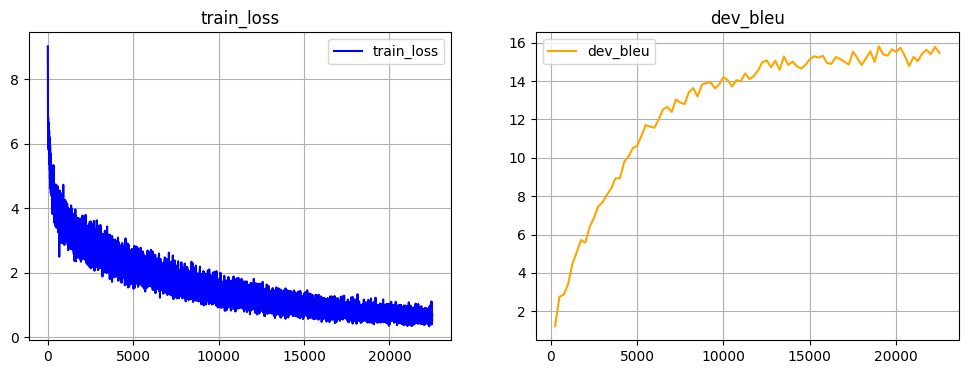

 90%|█████████ | 22502/25000 [36:19<20:30,  2.03it/s]

Шаг 22500: средний loss по последним 10 шагам = 0.604, BLEU = 15.47


 91%|█████████ | 22749/25000 [36:43<03:37, 10.33it/s]

Раннее прекращение обучения на шаге 22750. Лучший BLEU = 15.8168
Обучение завершено. Лучший BLEU = 15.82


In [12]:
for step in trange(1, steps+1):
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    current_loss_value = loss_t.item()
    metrics['train_loss'].append((step, current_loss_value))
    recent_losses.append(current_loss_value)

    if len(recent_losses) > 250:
        recent_losses.pop(0)

    # Каждые 250 шагов вычисляем валидационную loss и bleu на всем dev-наборе
    if step % 250 == 0:
        avg_train_loss = np.mean(recent_losses)
        scheduler.step(avg_train_loss)

        # Вычисляем BLEU (для ранней остановки)
        current_bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, current_bleu))

        # Логика ранней остановки (только после min_steps_for_early_stop)
        if step >= min_steps_for_early_stop:
            if current_bleu > best_bleu:
                best_bleu = current_bleu
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Раннее прекращение обучения на шаге {step}. Лучший BLEU = {best_bleu:.4f}")
                break
        else:
            # Если ещё не достигли min_steps_for_early_stop, просто печатаем BLEU
            if current_bleu > best_bleu:
                best_bleu = current_bleu
            print(f"Шаг {step}: BLEU = {current_bleu:.4f} (ранняя остановка включится после {min_steps_for_early_stop} шага)")

        # Отрисовка графиков
        clear_output(True)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1) # loss
        plt.title("train_loss")
        steps_loss, vals_loss = zip(*metrics['train_loss'])
        plt.plot(steps_loss, vals_loss, linestyle='-', color='blue', label="train_loss")
        plt.grid()
        plt.legend()
        plt.subplot(1, 2, 2) # bleu
        plt.title("dev_bleu")
        steps_bleu, vals_bleu = zip(*metrics['dev_bleu'])
        plt.plot(steps_bleu, vals_bleu, linestyle='-', color='orange', label="dev_bleu")
        plt.grid()
        plt.legend()
        plt.show()

        avg_loss_10 = np.mean([v for (_, v) in metrics['train_loss'][-10:]])
        print(f"Шаг {step}: средний loss по последним 10 шагам = {avg_loss_10:.3f}, BLEU = {current_bleu:.2f}")

print(f"Обучение завершено. Лучший BLEU = {best_bleu:.2f}")


In [13]:
compute_bleu(model, dev_inp, dev_out)

15.435749966412654

In [14]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines_sampling(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен.
with a bath, the bathroom also comes with a hairdryer.

на территории можно сыграть в дартс и сквош.
play room and a sandpit are available.

апартаменты располагают гостиной зоной.
the apartments include a seating area.

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне.
guests can cook their own meals in the fully-equipped kitchen.

к услугам гостей 2 спальни и 1 ванная комната с ванной и/или душем, а также кухня с духовкой и микроволновой печью.
there are 2 bedrooms and 1 bedroom, a living room and a bathroom with a bath and bidet, it also has a kitchen with an oven and a microwave.

ужин для гостей приготовят в ресторане ron@@ ni@@ e's win@@ gs & o@@ y@@ ster bar@@ .
guests at hotel friedrich@@ grande can relax at the c@@ r@@ amento lar@@ est@@ a, which to paris to relax at the gi@@ e of tel aviv equipped with a mini-@@ bar.



По самим переводам получилось не так плохо, но по метрикам получилось хуже, возможно из-за семплирования с температурой

#### Попробуем убрать   lr sheduling, early stopping

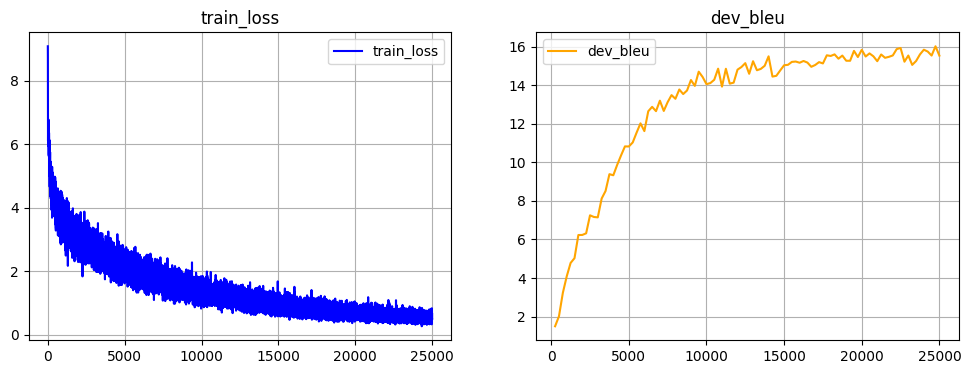

100%|██████████| 25000/25000 [41:12<00:00, 10.11it/s]

Шаг 25000: средний loss по последним 10 шагам = 0.551, BLEU = 15.54
Обучение завершено. Последний BLEU = 15.54


In [16]:
model = AdvancedAttentiveModel(inp_voc, out_voc, bidirectional=True, emb_size=256, hid_size=256, attn_size=256).to(device)
optimizer_choice = 'adam'
if optimizer_choice == 'adam':
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
elif optimizer_choice == 'sgd':
    opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

metrics = {'train_loss': [], 'dev_bleu': [] }

for step in trange(1, steps+1):
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()
    
    metrics['train_loss'].append((step, loss_t.item()))

    # Каждые 250 шагов вычисляем BLEU на всем dev-наборе и отрисовываем графики
    if step % 250 == 0:
        current_bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, current_bleu))

        # Отрисовка графиков в одинаковом формате для train_loss и dev_bleu
        clear_output(True)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)  # График train_loss
        plt.title("train_loss")
        steps_loss, vals_loss = zip(*metrics['train_loss'])
        plt.plot(steps_loss, vals_loss, linestyle='-', color='blue', label="train_loss")
        plt.grid()
        plt.legend()
        plt.subplot(1, 2, 2)  # График dev_bleu
        plt.title("dev_bleu")
        steps_bleu, vals_bleu = zip(*metrics['dev_bleu'])
        plt.plot(steps_bleu, vals_bleu, linestyle='-', color='orange', label="dev_bleu")
        plt.grid()
        plt.legend()
        plt.show()

        avg_loss_10 = np.mean([v for (_, v) in metrics['train_loss'][-10:]])
        print(f"Шаг {step}: средний loss по последним 10 шагам = {avg_loss_10:.3f}, BLEU = {current_bleu:.2f}")

print(f"Обучение завершено. Последний BLEU = {current_bleu:.2f}")

In [17]:
compute_bleu(model, dev_inp, dev_out)

15.399564653699347

In [18]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines_sampling(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен.
the bathrooms offer a bath, a hairdryer.

на территории можно сыграть в дартс и сквош.
you can play tennis, darts and darts on site.

апартаменты располагают гостиной зоной.
there is a seating area and a seating area.

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне.
guests can prepare meals in the fully-equipped kitchen.

к услугам гостей 2 спальни и 1 ванная комната с ванной и/или душем, а также кухня с духовкой и микроволновой печью.
the house offers two bedrooms, a bathroom with a bath or shower, a bath.

ужин для гостей приготовят в ресторане ron@@ ni@@ e's win@@ gs & o@@ y@@ ster bar@@ .
enjoy authentic lao cuisine in 5 h@@ end@@ vi@@ in fran@@ sch@@ ei@@ 's region in austri@@ a.



#### Попробуем оставить жадный выбор в семплировании


In [19]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

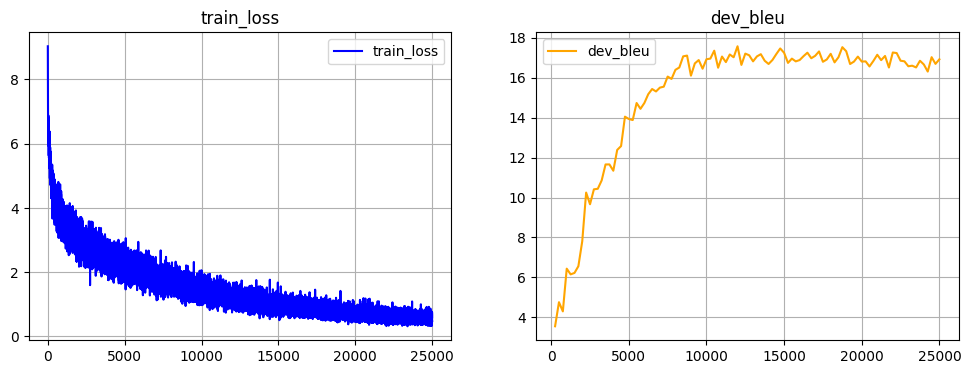

100%|██████████| 25000/25000 [39:58<00:00, 10.42it/s]

Шаг 25000: средний loss по последним 10 шагам = 0.581, BLEU = 16.92
Обучение завершено. Последний BLEU = 16.92


In [20]:
model = AdvancedAttentiveModel(inp_voc, out_voc, bidirectional=True, emb_size=256, hid_size=256, attn_size=256).to(device)
optimizer_choice = 'adam'
if optimizer_choice == 'adam':
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
elif optimizer_choice == 'sgd':
    opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

metrics = {'train_loss': [], 'dev_bleu': [] }

for step in trange(1, steps+1):
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()
    
    metrics['train_loss'].append((step, loss_t.item()))

    # Каждые 250 шагов вычисляем BLEU на всем dev-наборе и отрисовываем графики
    if step % 250 == 0:
        current_bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, current_bleu))

        # Отрисовка графиков в одинаковом формате для train_loss и dev_bleu
        clear_output(True)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)  # График train_loss
        plt.title("train_loss")
        steps_loss, vals_loss = zip(*metrics['train_loss'])
        plt.plot(steps_loss, vals_loss, linestyle='-', color='blue', label="train_loss")
        plt.grid()
        plt.legend()
        plt.subplot(1, 2, 2)  # График dev_bleu
        plt.title("dev_bleu")
        steps_bleu, vals_bleu = zip(*metrics['dev_bleu'])
        plt.plot(steps_bleu, vals_bleu, linestyle='-', color='orange', label="dev_bleu")
        plt.grid()
        plt.legend()
        plt.show()

        avg_loss_10 = np.mean([v for (_, v) in metrics['train_loss'][-10:]])
        print(f"Шаг {step}: средний loss по последним 10 шагам = {avg_loss_10:.3f}, BLEU = {current_bleu:.2f}")

print(f"Обучение завершено. Последний BLEU = {current_bleu:.2f}")

In [21]:
compute_bleu(model, dev_inp, dev_out)

16.917679316272846

In [22]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен.
the bathroom is fitted with a hairdryer and a bidet.

на территории можно сыграть в дартс и сквош.
a cash machine and game room are also available.

апартаменты располагают гостиной зоной.
the apartment is equipped with a seating area.

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне.
guests can prepare their meals in the full kitchen at their disposal.

к услугам гостей 2 спальни и 1 ванная комната с ванной и/или душем, а также кухня с духовкой и микроволновой печью.
there are 2 twin bedrooms and a bathroom with a shower and a living room with a bath, a shower and a kitchen with a toilet.

ужин для гостей приготовят в ресторане ron@@ ni@@ e's win@@ gs & o@@ y@@ ster bar@@ .
mol@@ j@@ an, chin@@ e’s casual american dishes for lunch and dinner.



Модель выходит на плато и не имеет прироста после 12000 эпох, тем не менее метрики с жадным выбором токенов показала лучше чем с семплированием с температурой. Также изменения в процессе обучения (scheduler, early stopping) имеют незначительно выше метрики, чем без них.